In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
import datetime
import time
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score

In [2]:
#Business Problem: Demand forecasting at Store-SKU level

data_raw  = pd.read_excel('DS_CaseStudy.xlsx', sheet_name='Train_Weeks')
data=data_raw.melt(id_vars=['sku','store']).copy()
data['Year']=np.floor(data['variable']/100)
data['Week']=data['variable'] %100
data['Day']=1

data.head()

,sku,store,variable,value,Year,Week,Day
0,1,1,201701,1,2017,1,1
1,1,2,201701,1,2017,1,1
2,1,3,201701,0,2017,1,1
3,1,4,201701,0,2017,1,1
4,1,5,201701,0,2017,1,1


In [3]:
# Getting Date from Year-Week
def getDateRangeFromWeek(p_year,p_week):

    firstdayofweek = datetime.datetime.strptime(f'{p_year}-W{int(p_week )- 1}-1', "%Y-W%W-%w").date() + datetime.timedelta(days=6.9)
    return firstdayofweek
data['Date'] = data[['Year','Week']].apply(lambda x : getDateRangeFromWeek(x[0],x[1]), axis=1)
data['Date']= pd.to_datetime(data['Date'])

#Feature Engineering
data['is_month_start'] = pd.DatetimeIndex(data['Date']).is_month_start
data['Month'] = pd.DatetimeIndex(data['Date']).month

data.head()

,sku,store,variable,value,Year,Week,Day,Date,is_month_start,Month
0,1,1,201701,1,2017,1,1,2017-01-01,True,1
1,1,2,201701,1,2017,1,1,2017-01-01,True,1
2,1,3,201701,0,2017,1,1,2017-01-01,True,1
3,1,4,201701,0,2017,1,1,2017-01-01,True,1
4,1,5,201701,0,2017,1,1,2017-01-01,True,1


                sku         store         value      Day         Month
count  13400.000000  13400.000000  13400.000000  13400.0  13400.000000
mean       1.500000     25.500000      2.098433      1.0      5.880597
std        0.500019     14.431408      2.588405      0.0      3.328081
min        1.000000      1.000000      0.000000      1.0      1.000000
25%        1.000000     13.000000      0.000000      1.0      3.000000
50%        1.500000     25.500000      1.000000      1.0      6.000000
75%        2.000000     38.000000      3.000000      1.0      9.000000
max        2.000000     50.000000     40.000000      1.0     12.000000


<Figure size 1296x216 with 0 Axes>

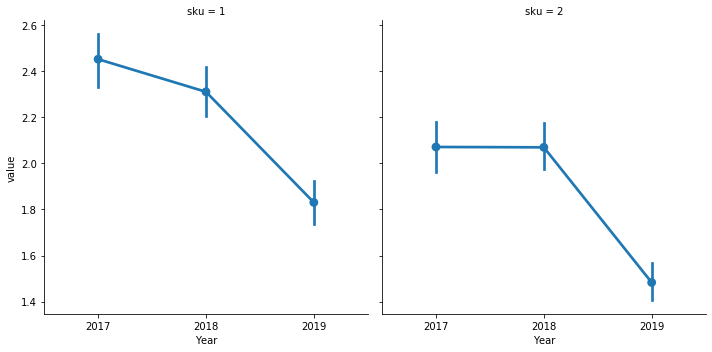

In [4]:
# Checking if 'NA' value is present: No missing value
data[data.isna().any(axis=1)]

# Univariate statistics
print(data.describe())

# SKU wise Average sales by Year:
# 1. Avg sales for SKU-1 has slightly decreased from 2017 to 2018 
# 2. Avg sales in 2019 has decreased since data is only available till week 30 and second half of the year shows higher sales
plt.figure(figsize=(18,3))
sns.catplot(data = data, x = 'Year', y = "value", col='sku', kind='point')

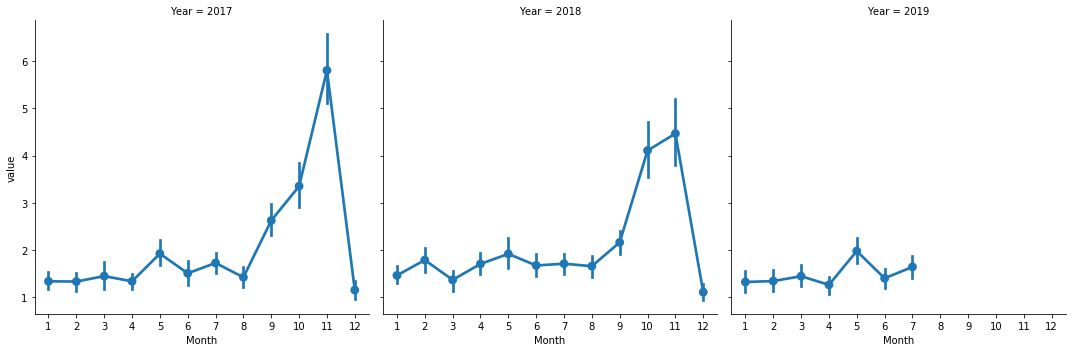

In [5]:
# Average sales by Month
# 1. Avg sales increases from Sep to Nov and then decreases again 
# 2. Second half of the year shows higher sales
# 3. Both SKUs show similar trend
# sns.catplot(data = data[data['sku']==1], x = 'Month', y = "value", col='Year', kind='point')
sns.catplot(data = data[data['sku']==2], x = 'Month', y = "value", col='Year', kind='point')


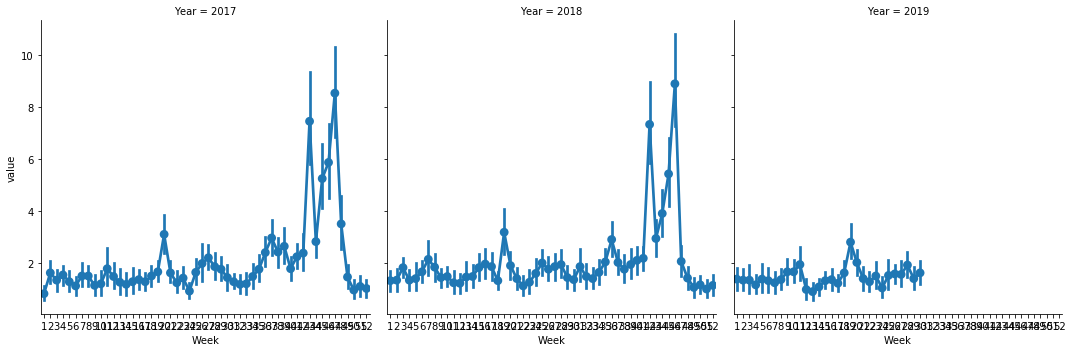

In [6]:
# Average sales by Week
# 1. There are specefic weeks when sales shoots up for both SKUs. Maybe becuase of holiday time
# sns.catplot(data = data[data['sku']==1], x = 'Week', y = "value", col='Year', kind='point')
sns.catplot(data = data[data['sku']==2], x = 'Week', y = "value", col='Year', kind='point')


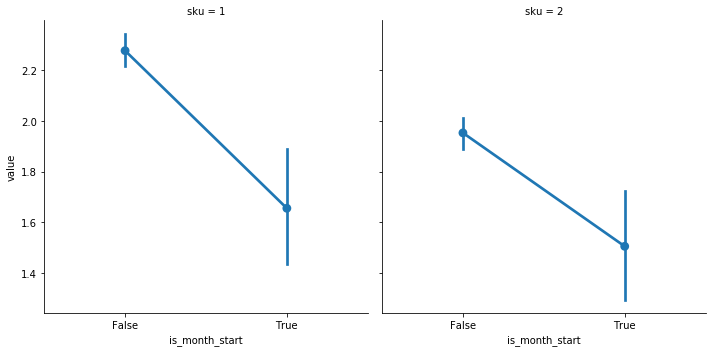

In [7]:
# Checking sales variation by month start/end
# 1. Start of the month shows lower sales and sales increases as month ends
# 2. Trend is similar for both SKUs
sns.catplot(data = data, x = 'is_month_start', y = "value", col='sku', kind='point')


In [8]:
# Sales Contribution by Store
# 1. All stores contribute almost uniformly. There is no skewness in sales by store. Can build an overall model for all stores  
Store_Sales = pd.DataFrame(data.groupby(["store"])["value"].sum()).reset_index()
Store_Sales = Store_Sales.sort_values(by = ['value'] , ascending=False)
Store_Sales['cumulative_percentage'] = 100 * (Store_Sales.value.cumsum()/Store_Sales.value.sum())

print('Top Stores by Sales','\n',Store_Sales.head(10))

Top Stores by Sales 
     store  value  cumulative_percentage
48     49   1071               3.808813
27     28   1021               7.439809
40     41    977              10.914328
45     46    966              14.349728
12     13    923              17.632206
17     18    846              20.640848
24     25    779              23.411217
31     32    742              26.050002
14     15    734              28.660336
32     33    733              31.267115


*** Additive Model ***


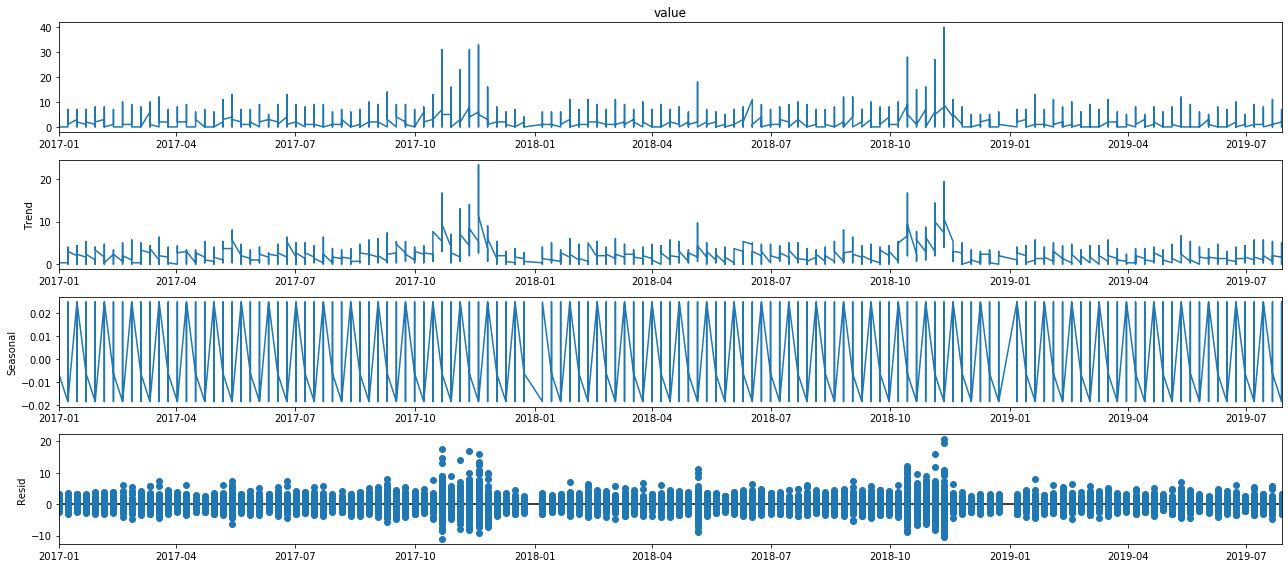

In [9]:
# Decomposing to deep dive into the series
# Checking the pattern across components (Trend, Seasonal and residual)  
print("*** Additive Model ***")

data_1=data.copy()
data_1['Date'] = pd.to_datetime(data_1['Date'], format='%Y%m', errors='coerce').dropna()
data_1 = data_1.set_index('Date')

rcParams['figure.figsize'] = 18, 8
decomposition_add = sm.tsa.seasonal_decompose(data_1['value'],period=3 ,model='additive')
fig = decomposition_add.plot()
plt.show()


In [10]:
# Conclusion:
# 1. There is a seasonality in sales as sales in lowers from Dec-Aug and then increases. This could be because SKUs are season specific.This trend is consistent across years
# 2. Both SKUs shows similar trend. A single model can be build for both SKUs
# 3. All stores have similar sales. There is no skewness in sales. We can build a single model for all stores
# There can different approach to build model at
    #  Approach 1: Non-time series model: Store level and attribute the sales to SKU level based on recent ratio of sales. Since both SKU show similar sales, a combined model can be built
    #  Approach 2: Time series model (e.g. ARIMA): Since there are many combination of Store-SKU, it is difficult to biult individual model for each combination
    
# Building an ML (Random Forest) model for sales forecasting (non-time series model)

    # Test: 201701-201815 (67 weeks) and Training: 201816-201930 (67 weeks) 
    # Target variable: Test = 201815 sales and Training = 201930 sales

    # Independent variable time period (30 weeks window): 
    # Test: 201701 - 201746 and Training: 201816 - 201908 

    # Prediction for week:
    #     1. 201931: using data of 201817-201909 time period
    #     2. 201952: using data of 201838-201930 time period

# Creating new feature based on previous weeks sales and last year trend as there is a seasonal pattern
    
test=data_raw[['store','sku',201701,201702,	201703,	201704,	201705,	201706,	201707,	201708,	201709,	201710,	201711,	201712,	201713,	201714,	201715,	201716,	201717,	201718,	201719,	201720,	201721,	201722,	201723,	201724,	201725,	201726,	201727,	201728,	201729,	201730,	201731,	201732,	201733,	201734,	201735,	201736,	201737,	201738,	201739,	201740,	201741,	201742,	201743,	201744,	201745,	201746,	201747,	201748,	201749,	201750,	201751,	201752,	201801,	201802,	201803,	201804,	201805,	201806,	201807,	201808,	201809,	201810,	201811,	201812,	201813,	201814,	201815]]
training=data_raw[['store','sku',201816,201817,	201818,	201819,	201820,	201821,	201822,	201823,	201824,	201825,	201826,	201827,	201828,	201829,	201830,	201831,	201832,	201833,	201834,	201835,	201836,	201837,	201838,	201839,	201840,	201841,	201842,	201843,	201844,	201845,	201846,	201847,	201848,	201849,	201850,	201851,	201852,	201901,	201902,	201903,	201904,	201905,	201906,	201907,	201908,	201909,	201910,	201911,	201912,	201913,	201914,	201915,	201916,	201917,	201918,	201919,	201920,	201921,	201922,	201923,	201924,	201925,	201926,	201927,	201928,	201929,	201930]]

#Feature Engineering
def Feature_Engineering(df,Forecast_period,model_type):
    warnings.filterwarnings("ignore")

    if np.floor(Forecast_period/100)==np.floor((Forecast_period-22)/100):
        end_period =Forecast_period-22
    else:
        end_period=int((np.floor(Forecast_period/100) -1)*100 + (53 - (22-Forecast_period%100)))
    # 1. Previous weeks avg sales (2/4/6/8 weeks) for current year
    j=1
    pre_period={}
    for i in range(1,46):
        if np.floor(end_period/100)==np.floor((end_period-i)/100) and (end_period-i)%100 >0:
            pre_period[j] =end_period-i+1
            j=j+1
        elif np.floor(end_period/100)==np.floor((end_period-i)/100) and (end_period-i)%100 ==0:
            pre_period[j] = end_period-i+1
            j=j+1
        elif np.floor(end_period/100)!=np.floor((end_period-i)/100) and (end_period-i)%100 >0:
            pre_period[j] = int((np.floor(end_period/100) -1)*100 + (53 - (i-end_period%100)))
            j=j+1    
    df['Avg_Sales_2weeks_TY']= (df[pre_period[1]] + df[pre_period[2]])/2
    df['Avg_Sales_4weeks_TY']= (df[pre_period[1]] + df[pre_period[2]] + df[pre_period[3]] + df[pre_period[4]])/4
    df['Avg_Sales_6weeks_TY']= (df[pre_period[1]] + df[pre_period[2]] + df[pre_period[3]] + df[pre_period[4]] + df[pre_period[5]] + df[pre_period[6]])/6
    df['Avg_Sales_8weeks_TY']= (df[pre_period[1]] + df[pre_period[2]] + df[pre_period[3]] + df[pre_period[4]] + df[pre_period[5]] + df[pre_period[6]] + df[pre_period[7]] + df[pre_period[8]])/8

    # 2. Last year avg sales in the same time period (2/4/6/8 weeks)
    j=1
    LY_pre_period={}
    for i in range(0,8):
        if np.floor(Forecast_period/100)==np.floor((Forecast_period-i)/100) and (Forecast_period-i)%100 >0:
            LY_pre_period[j] = int((np.floor(Forecast_period/100) -1)*100 + (Forecast_period-i+1)%100)
            j=j+1
        elif np.floor(Forecast_period/100)==np.floor((Forecast_period-i)/100) and (Forecast_period-i)%100 >0:
            LY_pre_period[j] = int((np.floor(Forecast_period/100) -2)*100 + (53 - (i-Forecast_period%100)))
            j=j+1

    df['Avg_Sales_2weeks_LY']= (df[LY_pre_period[1]] + df[LY_pre_period[2]])/2
    df['Avg_Sales_4weeks_LY']= (df[LY_pre_period[1]] + df[LY_pre_period[2]] + df[LY_pre_period[3]] + df[LY_pre_period[4]])/4
    df['Avg_Sales_6weeks_LY']= (df[LY_pre_period[1]] + df[LY_pre_period[2]] + df[LY_pre_period[3]] + df[LY_pre_period[4]] + df[LY_pre_period[5]] + df[LY_pre_period[6]])/6
    df['Avg_Sales_8weeks_LY']= (df[LY_pre_period[1]] + df[LY_pre_period[2]] + df[LY_pre_period[3]] + df[LY_pre_period[4]] + df[LY_pre_period[5]] + df[LY_pre_period[6]] + df[LY_pre_period[7]] + df[LY_pre_period[8]])/8
    
    # 3. Velocity variable: Checking if the sale is increasing or decreasing last in the same time period and creating slope/ratio variables to capture change in sale    
    df['2_vs_4week_LY_ratio']=df['Avg_Sales_2weeks_LY']/df['Avg_Sales_4weeks_LY']
    df['2_vs_6week_LY_ratio']=df['Avg_Sales_2weeks_LY']/df['Avg_Sales_6weeks_LY']
    df['2_vs_8week_LY_ratio']=df['Avg_Sales_2weeks_LY']/df['Avg_Sales_8weeks_LY']
    df['4_vs_6week_LY_ratio']=df['Avg_Sales_4weeks_LY']/df['Avg_Sales_6weeks_LY']
    df['4_vs_8week_LY_ratio']=df['Avg_Sales_4weeks_LY']/df['Avg_Sales_8weeks_LY']
    
    df.fillna(0)
    X_df_1=df[pre_period.values()]
    X_df_1.columns=list(pre_period.keys())
    X_df_2=df[['Avg_Sales_2weeks_LY','Avg_Sales_4weeks_LY','Avg_Sales_6weeks_LY','Avg_Sales_8weeks_LY','2_vs_4week_LY_ratio','2_vs_6week_LY_ratio','2_vs_8week_LY_ratio','4_vs_6week_LY_ratio','4_vs_8week_LY_ratio']]
    X_df=pd.concat([X_df_1,X_df_2], axis=1)
    
    X_df[X_df.isna()==True]=0
    
    if model_type=='dev':
        y_df=df[Forecast_period]
        return X_df, y_df
    if model_type=='forecast':
        return X_df

X_training, y_training=Feature_Engineering(training, 201930, 'dev')
X_test, y_test=Feature_Engineering(test, 201815, 'dev')

# Building the model
RF = RandomForestRegressor(n_estimators = 300, random_state = 11, max_depth=10, max_features=12,min_samples_split=5, min_weight_fraction_leaf=0.0)

# Train the model on training dataset
RF.fit(X_training, y_training)
print(X_test.shape,X_training.shape)
Predict=RF.predict(X_test)

(100, 54) (100, 54)


In [11]:
#Performance metrics
print('MAE:', metrics.mean_absolute_error(y_test, Predict))
print('MSE:', metrics.mean_squared_error(y_test, Predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, Predict)))
print('R2:', np.sqrt(metrics.r2_score(y_test, Predict)))

MAE: 1.425297853864545
MSE: 3.0040487206150295
RMSE: 1.733219178469656
R2: 0.20924585945682408


In [12]:
# Predicting for future weeks (201931-201952)
Predict=data_raw[['sku','store']]
for i in range(201931,201952):
    X_training_temp=Feature_Engineering(data_raw, i, 'forecast')
    Predict_temp=pd.DataFrame(RF.predict(X_training_temp))
    Predict=pd.concat([Predict, Predict_temp], axis=1)

Predict.to_csv('Submission.csv')